# Gather Starling Data
#### Date: 8/30/2022, JX
> Gather local starling data from https://doi.org/10.5281/zenodo.3237218 and get amplitude envelopes


In [1]:
from starling_rhythm.utils.paths import DATA_DIR

## Get list of wavs

In [2]:
from pathlib import Path
from glob import glob

In [3]:
wav_paths = list(Path(DATA_DIR).rglob("*.wav"))

In [4]:
wav_paths

[PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-13_16-29-28-410000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-16_15-17-52-520000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-20_14-15-32-360000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-20_12-40-56-130000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-15_15-30-01-000000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-14_18-55-35-670000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-13_13-34-33-350000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-15_15-21-11-060000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053/wavs/2017-11-15_15-37-23-000000.wav'),
 PosixPath('/mnt/cube/Datasets/public_ds_starlings_ts_2019/b1053

## Extract Amplitude Envelope

In [5]:
from starling_rhythm.utils.audio import extract_amp_env
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed

/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
n_jobs = 36 ## joblib setting
verbose = 0

In [7]:
with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    amp_envs = parallel(
        delayed(extract_amp_env)(
            wav_path,
            target_sr = 1000, ## each number is 1 ms
            win_type = 'boxcar', ## smooth with boxcar window (rolling average)
            res_type = 'linear' ## linear resample
        )
        for wav_path in tqdm(wav_paths, desc = 'Extracting Amplitude Envelope')
    )

Extracting Amplitude Envelope:   1%|▏         | 144/10500 [00:23<34:17,  5.03it/s]/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Extracting Amplitude Envelope: 100%|██████████| 10500/10500 [32:16<00:00,  5.42it/s]


## Fit into Dataframe

In [8]:
import numpy as np
import pandas as pd

In [9]:
columns = np.transpose(amp_envs)

/home/AD/j8xing/anaconda3/envs/starling_rhythm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [10]:
bID = columns[0]
wav_file = columns[1]
amp_env = columns[2]

In [11]:
amp_df = pd.DataFrame(
    {
        "bID":bID,
        "wav_file":wav_file
    }
)

In [12]:
amp_df = amp_df[amp_df['bID'] != 0] ## prune bID to excluded improperly loaded wavs

## Proof

In [13]:
import matplotlib.pyplot as plt
from scipy.io.wavfile import read

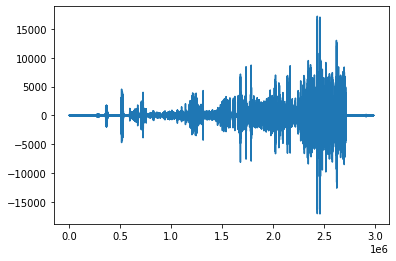

In [14]:
plt.plot(read(wav_paths[1])[1])

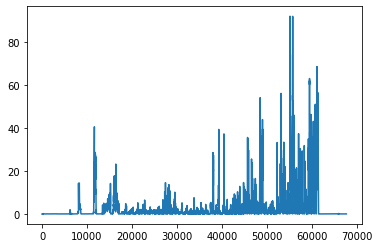

In [15]:
plt.plot(amp_df.amp_env.values[1])

## Pickle dataframe

In [16]:
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir

In [17]:
SAVE_PATH = PROCESSED_DIR / 'starling_zenodo_2019_amp_envs.pickle'
ensure_dir(SAVE_PATH)

In [18]:
amp_df.to_pickle(SAVE_PATH)